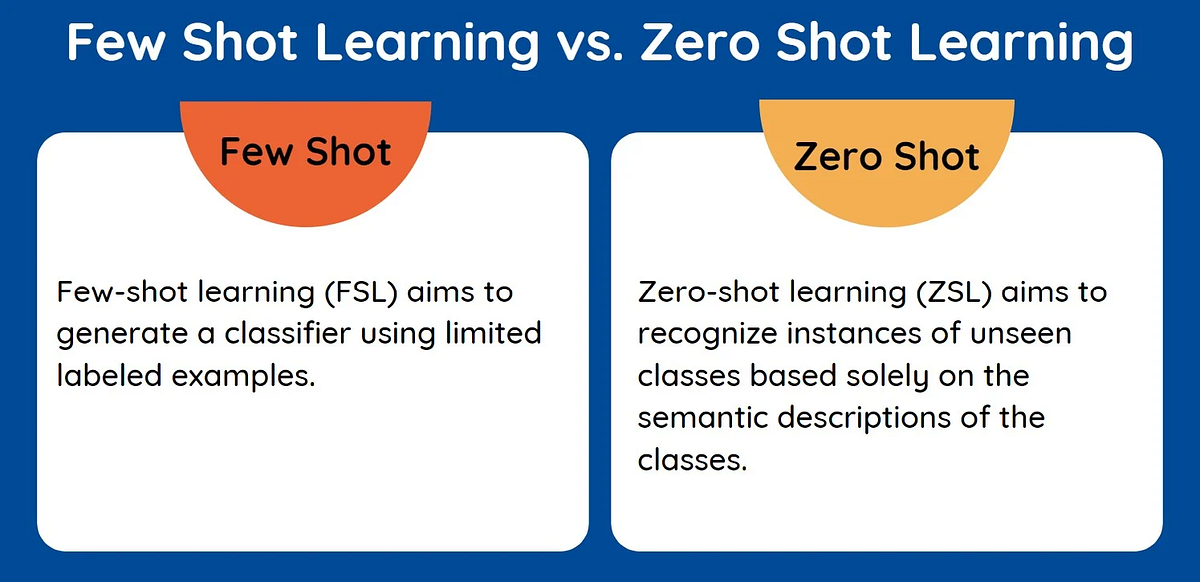

In this notebook we'll test a zero-shot classification approach on our shortened version of the emails dataset contaning 6 categories:
<ol>
<li>Rechungen
<li>Storno
<li>Mahnungen
<li>Tarife
<li>Aktivierung Sim
<li>Vertraege und Vereinbarung
</ol>
We'll use the transformers library for the task which requires tensorflow version >= 2.14.

In [1]:
import tensorflow as tf

# if version >= 2.14 proceed, else uncomment and the run the following cell
tf.__version__

'2.15.0'

In [2]:
# !pip install tensorflow -U

## Data pre-processing

In [3]:
ls

emails_df.csv  sample_data/


In [4]:
import pandas as pd

df = pd.read_csv('emails_df.csv')

In [5]:
df

,Unnamed: 0,Category,Email,Content
0,0,TARIFE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t0...
1,1,TARIFE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...
2,2,TARIFE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
3,3,TARIFE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
4,4,TARIFE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t3...
...,...,...,...,...
360,360,VERTRAEGE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
361,361,VERTRAEGE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
362,362,VERTRAEGE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...
363,363,VERTRAEGE,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t1...


In [6]:
df['Category'].value_counts()

TARIFE         109
VERTRAEGE       92
AKTIVIERUNG     77
RECHNUNGEN      57
MAHNUNGEN       19
STORNO          11
Name: Category, dtype: int64

In [7]:
df.shape

(365, 4)

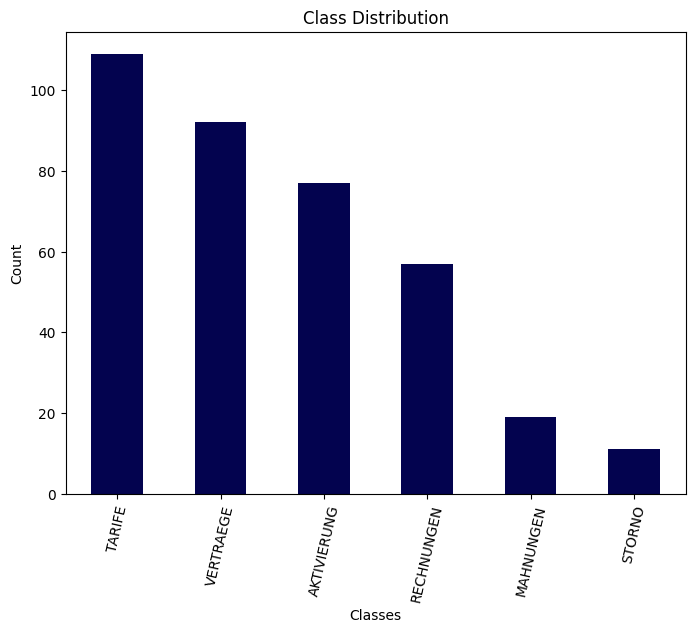

In [8]:
# class distribution

import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = df['Category'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=(0.01,0.01,0.31))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=77)  # Rotate x-axis labels if needed
plt.show()

In [9]:
import quopri

def decode_quoted_printable(text):
    if isinstance(text, str):
        try:
            # Convert string to bytes, decode using quopri, and then decode to iso-8859-1
            decoded = quopri.decodestring(text.encode('latin1')).decode('iso-8859-1')
            return decoded
        except Exception as e:
            return str(e)
    return text

df['Content_fixed'] = df['Content'].apply(decode_quoted_printable)

In [10]:
print(df['Content_fixed'][44])

An:	KUNDENSERVICE@EPLUS
Kopie:	 
Datum:	29.10.2001 19:18:59
Betreff:	E-Mail Beantwortung

	  



Anrede         : Frau
Name           : Stephanie Dallmann
Handyrufnummer : 49 177 3842820
Account Nummer :
Handymodell    : Nokia 3310
Provider       : E-Plus Service
Email          : sdallmann@web.de
-------------------------------------
Nachricht      : Sehr geehrtes E-Plus Team,
in welchem Ihrer Tarife ist die automatische Rufumleitung auf ein anders 
Handy kostenfrei?
Mit freundlichen Grüßen
Dallmann Stephanie
-------------------------------------
--443437766.1004379539411.JavaMail.nsuser@apps1mn1--




In [11]:
# function to fetch the email body
def fetch_body(text):

    my_text = text.split('Nachricht      : ')[-1]

    text =  my_text.split('--')[0]

    return text.replace('\n', ' ')

df['Email_body'] = df['Content_fixed'].apply(fetch_body)

In [12]:
x = df['Email_body'][250]
x

"Sehr geehrte Damen und Herren,  ich habe versehentlich 3 mal die falsche PIN eingegeben und verfüge über  keine PUK mehr. Mein Geheimwort lautet mustang. 'Es wäre schön, wenn Sie  mir helfen könnten.  Mit freundlichen Grüßen  annette schneider-solis "

For this task we don't need to further preprocess our text data which was what we did when we used traditional ML (Linear SVC, Multinomial NB, Random Forest) and Flair model for few-shot learning. We can pass a normal string containing punctuation, words in different case, numbers etc. to a pre-trained model like GPT or BERT.

In [13]:
df['Category'].unique()

array(['TARIFE', 'RECHNUNGEN', 'MAHNUNGEN', 'STORNO', 'AKTIVIERUNG',
       'VERTRAEGE'], dtype=object)

In [14]:
df['Category'] = df['Category'].map({'RECHNUNGEN': 'Rechnungen', 'TARIFE': 'Tarife', 'STORNO': 'Storno', 'MAHNUNGEN': 'Mahnungen', 'VERTRAEGE': 'Verträge und Vereinbarungen', 'AKTIVIERUNG':'Sim-Karten-Aktivierung'})

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.head()

,Unnamed: 0,Category,Email,Content,Content_fixed,Email_body
0,193,Storno,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,Edmund Becker Ernst-Tamm-Str. 47 25746 Heide ...
1,232,Sim-Karten-Aktivierung,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t1...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t1...,ich möchte eine neue rufnummer nach meinen wun...
2,125,Rechnungen,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,bezüglich Rechnung-Nr. 4062558220 Kd.-Nr. 1121...
3,64,Tarife,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t2...,"Hallo, mein Tarif Professional XL, somit koste..."
4,168,Mahnungen,<_io.TextIOWrapper name='datasets/short_emails...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t0...,An:\tKUNDENSERVICE@EPLUS\nKopie:\t \nDatum:\t0...,An:\tKUNDENSERVICE@EPLUS Kopie:\t Datum:\t09....


Models we'll use for zero-shot classification: <br>

<center>

| Model | Base model  |
|---|---|
| German_zeroshot | GBERT Large |
| Gbert Large Zeroshot Nli | GBERT Large |
| German-GPT2| GPT-2 |
|   |   |

</center>

## Template functions for zero-shot classification

In [41]:
def load_model(pre_trained_model_name):

  from transformers import pipeline

  classifier = pipeline("zero-shot-classification",
                      model=pre_trained_model_name)

  return classifier

def display_confusion_matrix(predicted, actual, labels):

  from sklearn import metrics

  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                              display_labels=labels)

  cm_display.plot()
  plt.xticks(rotation=270)
  plt.show()


def predict_label_first_10(labels_list, classifier_model):

  candidate_labels = labels_list

  # define empty lists to further calculate model accuracy
  predicted = []
  actual = []

  # sim-karten-aktivierung <- aktivierung der sim-karte
  for ind, row in df.head(10).iterrows():

    sequence = row['Email_body']

    prediction = classifier_model(sequence, candidate_labels)

    # fetch predicted value
    pred = str(prediction['labels'][0])

    # fetch the actual value
    act = str(row['Category'])

    print(f"{ind+1}. Sentence: {sequence}")
    print(f"   Predicted label: {pred}; Actual label: {act}")
    print()


def predict_label_full_dataset(labels_list, classifier_model):

  candidate_labels = labels_list

  # define empty lists to further calculate model accuracy
  predicted = []
  actual = []

  # sim-karten-aktivierung <- aktivierung der sim-karte
  for ind, row in df.iterrows():

    sequence = row['Email_body']

    prediction = classifier_model(sequence, candidate_labels)

    # fetch predicted value
    pred = str(prediction['labels'][0])

    # fetch the actual value
    act = str(row['Category'])

    # append predicted and actual values
    actual.append(act)
    predicted.append(pred)

  return predicted, actual


def calculate_accuracy(predicted_labels, actual_labels):
  correct_predictions = sum(p == a for p, a in zip(predicted_labels, actual_labels))
  total_predictions = len(predicted_labels)
  accuracy = correct_predictions / total_predictions
  return f"{accuracy * 100:.0f}%"

## Zero-shot classification using <a href="https://huggingface.co/Sahajtomar/German_Zeroshot">German-Zeroshot<a>

In [18]:
classifier = load_model("Sahajtomar/German_Zeroshot")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Let's predict email categories for the first 10 emails in our DataFrame:

In [19]:
predict_label_first_10(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    classifier
)

1. Sentence: Edmund Becker Ernst-Tamm-Str. 47  25746 Heide  geb.: 11.09.1977   Sehr geehrte Damen und Herren,  hiermit möchte ich bitten, meine E-Plus Free&Easy-Karte mit der nummer:  01773625645 zu löschen.Ich benötige diese Karte nicht mehr. Wenn Sie diese  getan haben , möchte ich Sie ausserdem bitten mir kurz eine bestätigung  per E-Mail zu senden, wo drinne steht das auf meinen Namen weder  Vertrags-Karten noch Prepaid-Karten registriert sind.  Die Kartendaten:  Kartennummer:53-810-005481-7 Handynummer: 01773625645   Vielen Dank im voraus für Ihre Bemühungen   Mit freundlichen Grüssen   Edmund Becker 
   Predicted label: Storno; Actual label: Storno

2. Sentence: ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir schnellstmöglich mit, ob diese nummern noch frei sind  und wie ich sie bekomme 
   Predicted label: Tarife; Actual label: 

In [20]:
predicted, actual = predict_label_full_dataset(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    classifier
)

In [24]:
print(f"Accuracy of the German-Zeroshot classifier: {calculate_accuracy(predicted, actual)}")

Accuracy of the German-Zeroshot classifier: 42%


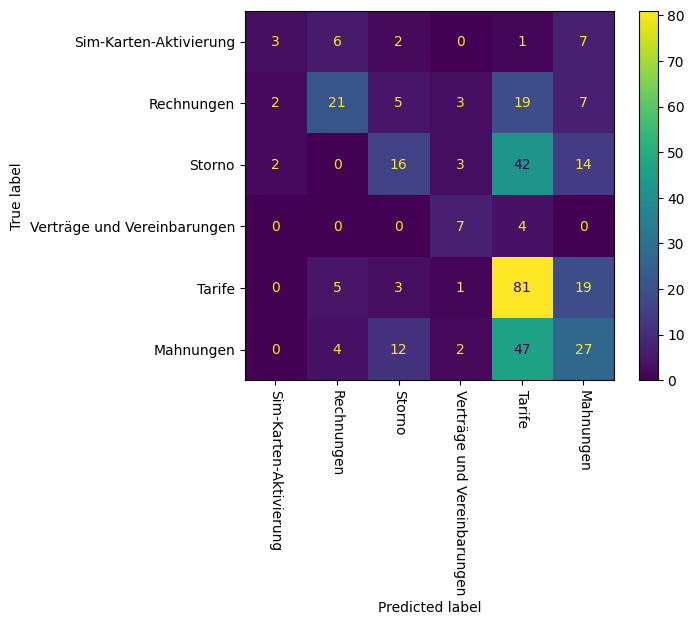

In [42]:
display_confusion_matrix(predicted, actual, ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"])

The problem I encountered while trying out ore-trained models for zero-chot classification is that Class Description play huge role for correct text labeling by the model. Initially, the model wasn't ablt to detect the emails belonging to the category "Aktivierung der SIM-Karte" and was assigning the label "Tarif", but when I changed the class name to "Sim-Karten-Aktivierung" it started working. Also, the model overfits on some more general classes like "Tarife" and "Vertrage and Vereinbarungen" while failing to capture the essence of more specific classes like "Sim-Karten-Aktivierung" and "Mahnungen"

## Zero-shot classification using <a href="https://huggingface.co/svalabs/gbert-large-zeroshot-nli">Gbert Large Zeroshot Nli<a>

In [43]:
gbert_nli_classifier = load_model("svalabs/gbert-large-zeroshot-nli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [44]:
predict_label_first_10(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    gbert_nli_classifier
)

1. Sentence: Edmund Becker Ernst-Tamm-Str. 47  25746 Heide  geb.: 11.09.1977   Sehr geehrte Damen und Herren,  hiermit möchte ich bitten, meine E-Plus Free&Easy-Karte mit der nummer:  01773625645 zu löschen.Ich benötige diese Karte nicht mehr. Wenn Sie diese  getan haben , möchte ich Sie ausserdem bitten mir kurz eine bestätigung  per E-Mail zu senden, wo drinne steht das auf meinen Namen weder  Vertrags-Karten noch Prepaid-Karten registriert sind.  Die Kartendaten:  Kartennummer:53-810-005481-7 Handynummer: 01773625645   Vielen Dank im voraus für Ihre Bemühungen   Mit freundlichen Grüssen   Edmund Becker 
   Predicted label: Verträge und Vereinbarungen; Actual label: Storno

2. Sentence: ich möchte eine neue rufnummer nach meinen wunschen: wunschrufnummern (vorschläge) - 0163/2090090 - 0178/2090090 - 0177/1090090 oder 20.. 30.. usw - 0177/2090091 oder 0177/2090089 bitte teilen sie mir schnellstmöglich mit, ob diese nummern noch frei sind  und wie ich sie bekomme 
   Predicted label: V

In [45]:
predicted, actual = predict_label_full_dataset(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    gbert_nli_classifier
)

In [47]:
print(f"Accuracy of the Gbert Large Zeroshot Nli classifier: {calculate_accuracy(predicted, actual)}")

Accuracy of the Gbert Large Zeroshot Nli classifier: 51%


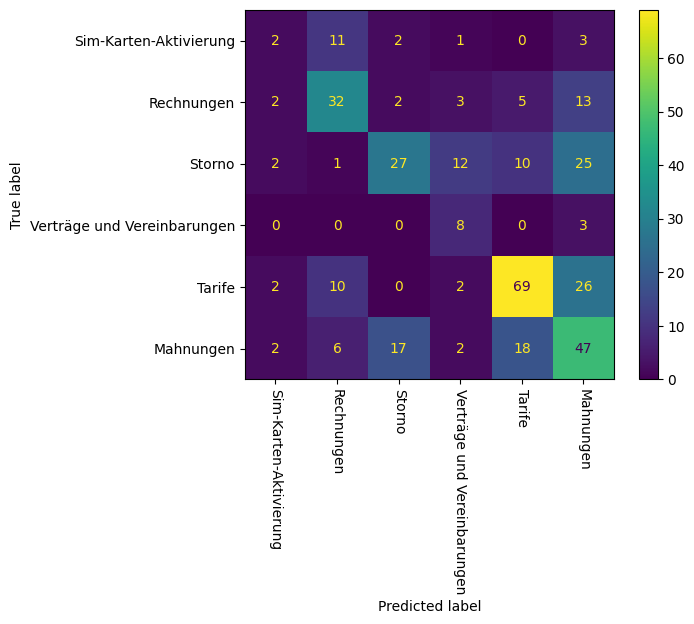

In [48]:
display_confusion_matrix(predicted, actual, ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"])

## Zero-shot classification using <a href="https://huggingface.co/dbmdz/german-gpt2">German GPT-2</a>

In [57]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")

model = AutoModelWithLMHead.from_pretrained("dbmdz/german-gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [58]:
from transformers import pipeline

german_gpt2_classifier = pipeline(
    'zero-shot-classification',
    model='dbmdz/german-gpt2',
    tokenizer='dbmdz/german-gpt2'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [60]:
predicted, actual = predict_label_full_dataset(
    ["Sim-Karten-Aktivierung", "Rechnungen", "Storno", "Verträge und Vereinbarungen", "Tarife", "Mahnungen"],
    german_gpt2_classifier
)

In [61]:
calculate_accuracy(predicted, actual)

'21%'